### Colab setup (can safely delete if you are running locally):

In [ ]:
# ONLY RUN IN COLAB ONCE:
# Clean & Fast Setup (run once per session)
import os, sys, subprocess
from pathlib import Path

repo_url = "https://github.com/Leibniz-IWT/comp_eng.git"
repo_dir = "comp_eng"

if not Path(repo_dir).exists():
    print("Cloning repository (shallow clone - fast)...")
    !git clone --depth 1 {repo_url} {repo_dir} -q
else:
    print("Repository already cloned.")

%cd {repo_dir}/project_handout

# Make station_model importable
sys.path.insert(0, os.path.abspath("."))

# Install dependencies quietly
print("Installing dependencies...")
!pip install -q numpy scipy matplotlib sympy gymnasium stable-baselines3[extra] ipywidgets


print("✅ Setup complete! You can now open the handout notebook.")

# Station Keeping Sub-Problem 2: Attitude Control Simulation

In this notebook, we simulate the attitude control of the space station using a PID controller to maintain proper alignment with its velocity vector. We will visualize the alignment error, attitude angle, and fuel consumption over a 600-second interval.

This episode represents a sub-problem of the overall station-keeping task, which attempts to solve an attitude control within the 600 seconds of a main time step. The attitude control is performed in smaller sub-steps (10 seconds each) to allow for more frequent adjustments. Note that better control performance can be achieved by tuning the PID controller parameters (Kp, Ki, Kd). There is also a numerical aspect where lowering the control time step (dt_sub) can improve performance, but at the cost of increased computational effort. For the purposes of this exercise, we will keep dt_sub = 10 seconds for the final simulation (which mimics challengers in slow response digital control systems), but this value can be adjusted .


In the code below, you can adjust:
- The PID controller parameters (Kp, Ki, Kd) to see their effect on the control performance.
- The desired alignment angle (alpha_setpoint) to see how the controller tracks different targets (e.g. a RL trained agent might command a small offset to counteract disturbances, while other policies could have more aggressive control).
- The initial misalignment angle (current_psi) to see how the controller responds to different starting conditions.

For the purposes of grading this sub-problem is considered "successful" if the final alignment error is less than 10 degrees (0.17 radians) withing the setpoint. After completing the task, the simulation remains useful for minimizing fuel consumption while maintaining alignment (or prioritizing alignment over fuel use).

> HINT 1: The PID controller parameters (Kp, Ki, Kd) can be adjusted to see their effect on the control performance. Try different values to observe how they influence the alignment error and fuel consumption. For this control problem, a good starting point might be relatively small Kp values (<<1) and much smaller integral control relative to proportional control (Ki << Kp).

> HINT 2: While it's possible to achieve good performance with only PID control, more advanced control strategies (e.g., model predictive control, reinforcement learning) could potentially yield better results. In order to do this you need to redefine `env.control_signal` and replace this function with your own custom code, see the final cell of this notebook for skeleton code to implement a new control strategy. Using more advanced control strategies it is possible to obtain very fast response with 0.00 degree alignment error while expending only ~0.0033 kg pf fuel over the 600 second interval.

The code below runs the attitude control sub-problem simulation and plots the results, allowing you to tune and visualize the performance of the PID controller:

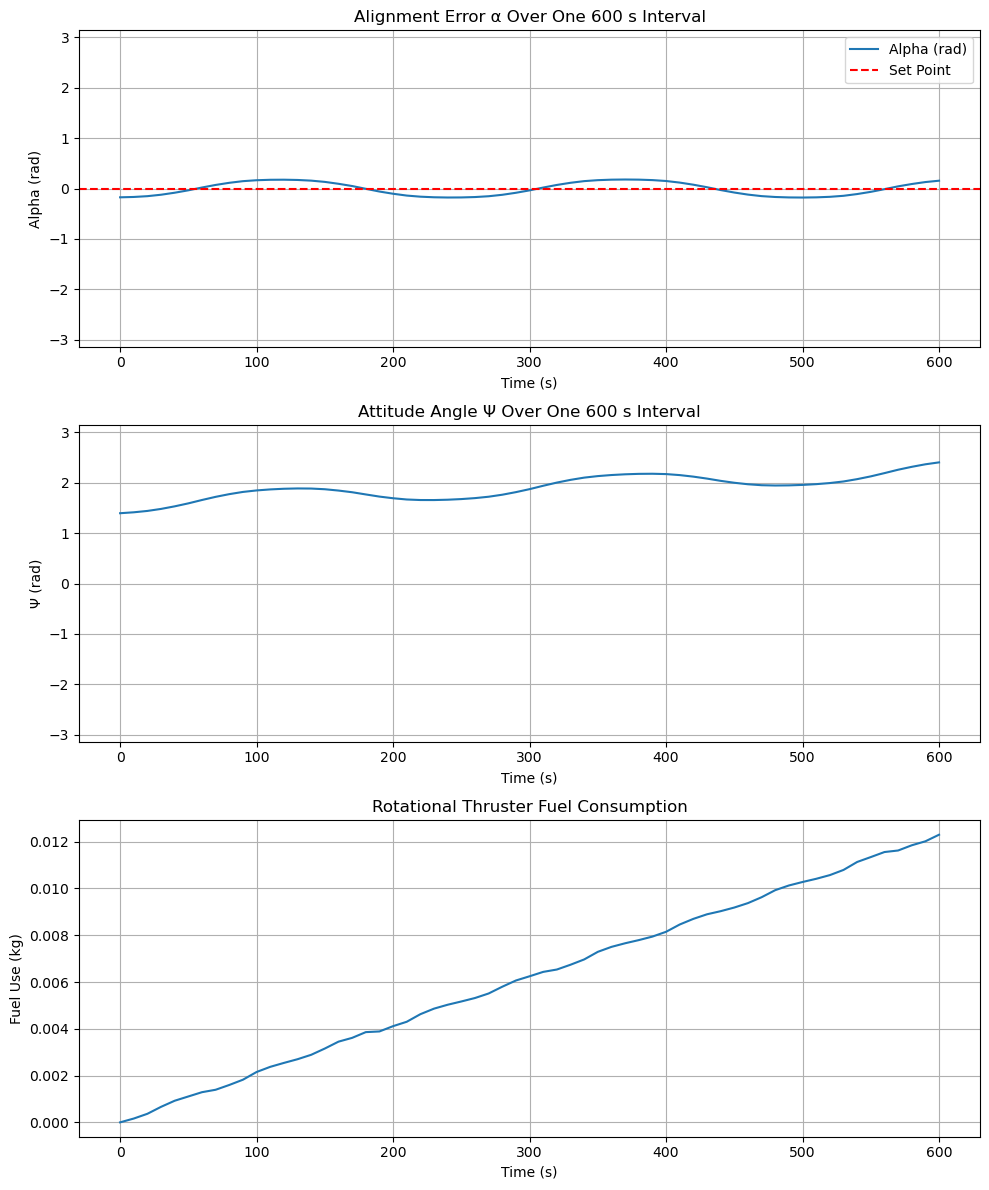

Final alignment error α: 8.90°
Total rotational fuel used: 0.0123 kg
Attitude control successful: Alignment within ±10°.


In [ ]:
from station_model._sub_problem import attitude_control_sub_problem
from station_model._environment import OrbitMaintenanceEnv

# Instantiate environment
env = OrbitMaintenanceEnv()

# Tune PID gains (try different values!)
env.Kp = 0.1
env.Ki = 0.01
env.Kd = 0.1

# Run the attitude control sub-problem simulation and plot results
alphas, psis, cum_fuel_rot, total_fuel_rot = attitude_control_sub_problem(env, alpha_setpoint=0.0, current_psi=-10, dt_sub=10)

## Implementing Advanced Control Strategies

The skeleton code below provides a starting point for implementing more advanced control strategies, such as Model Predictive Control (MPC) or Reinforcement Learning (RL). You can modify the `advanced_control_policy` function to implement your desired control algorithm.

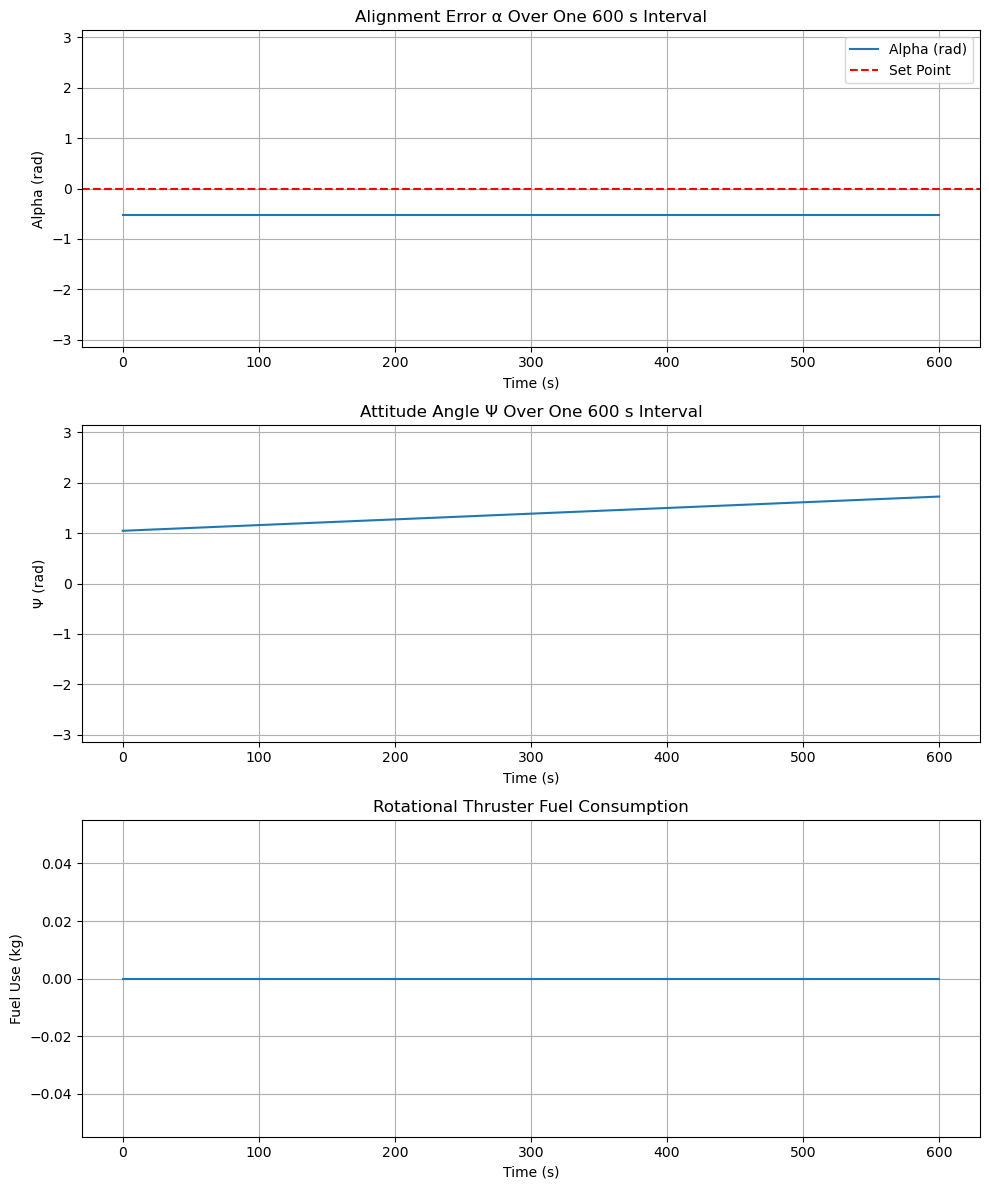

Final alignment error α: -30.00°
Total rotational fuel used: 0.0000 kg
Attitude control failed: Alignment outside ±10°.


In [ ]:
import numpy as np
from scipy import optimize
from types import MethodType
from station_model._sub_problem import attitude_control_sub_problem
from station_model._environment import OrbitMaintenanceEnv

# Instantiate environment
env = OrbitMaintenanceEnv()

# Defin your own custom control parameters, for example MPC hyperparameters (tune directly on the instance):
env.horizon = 10          # sub-steps lookahead (~100 s)
env.Q = 100.0             # strong penalty on alignment error
env.R = 0.8               # moderate penalty on control effort
env.u_max = 10.0          # symmetric bound on raw signal u

# Define the advanced control signal method:
# (NOTE: This API should remain compatible with the original control_signal signature)
def advanced_control_signal(self, error, integral_error, derivative,
                       current_psi, current_omega, target_alpha, dt_sub):
    """
    Receding-horizon MPC.
    Signature matches original control_signal exactly.
    Returns raw u (same as PID output) → later clipped to valves.
    """
    # Implement your advanced control strategy here, use self.# to access environment properties.
    # For example, you could implement a Model Predictive Control (MPC) algorithm or use a trained RL agent.
    # ...
    # Placeholder implementation: simple PID control (replace with your own logic)
    signal = 0
    return signal

# Explicitly bind the new method to the instance:
env.control_signal = MethodType(advanced_control_signal, env)

# Test by running the attitude control sub-problem simulation
alphas, psis, cum_fuel_rot, total_fuel_rot = attitude_control_sub_problem(
    env, alpha_setpoint=0.0, current_psi=-30, dt_sub=10
)
